#### Импорты

In [68]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import subprocess
import pickle
from module import *

#### Моделирование регистрации фотонов SiPM

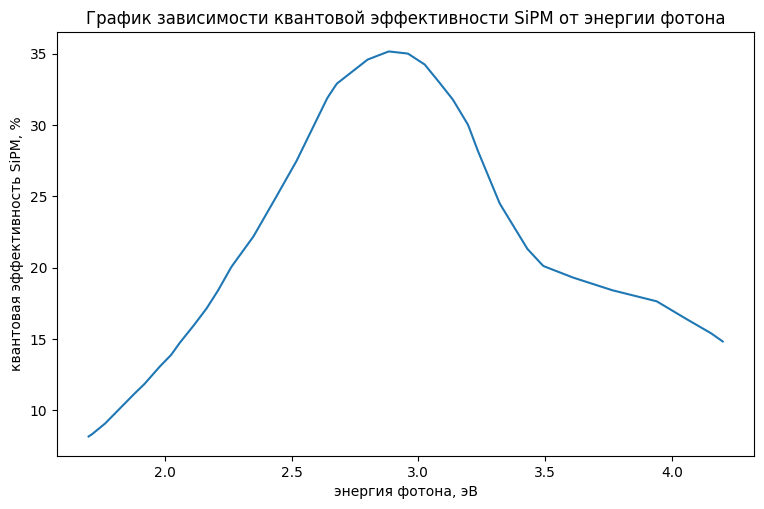

In [69]:
plt.figure(figsize=(9, 5.5))
plt.title("График зависимости квантовой эффективности SiPM от энергии фотона")
plt.xlabel("энергия фотона, эВ")
plt.ylabel("квантовая эффективность SiPM, %")
plt.plot(qe_e, qe_q)
plt.show()

##### Преобразование Бокса-Мюллера для получения случайной величины из распределения Гаусса:  
$z_0 = cos(2 \pi \phi) \sqrt{-2 * ln(r)}$

$z = \mu + \sigma * z_0$  
$\mu = 0.201912 мВ$  
$\sigma = 0.034257 мВ$  


In [70]:
events_path = "EVENTS_DATA" # расположение папки с данными
for folder in tqdm(os.listdir(events_path)):
    subprocess.Popen(["python", "calculate_amplitude.py", folder]) # используем параллельные вычисления для ускорения счёта

trash_path = "Trash"
res = []
events_count = len(os.listdir(events_path))
while len(os.listdir(trash_path)) != events_count: # ждём пока всё посчитается
    pass
for file in tqdm(os.listdir(trash_path)):
    with open(os.path.join(trash_path, file), 'rb') as l:
        res.append(pickle.load(l))
for file in os.listdir(trash_path):
    os.remove(os.path.join(trash_path, file))

100%|██████████| 11/11 [00:00<00:00, 2765.20it/s]


In [71]:
summary = {}
for i in range(0, 1152):
    summary[i] = 0
N = 0
for i in range(len(res)):
    for j in range(len(res[i]) - 1):
        summary[j] += res[i][j]
    N += res[i][-1]

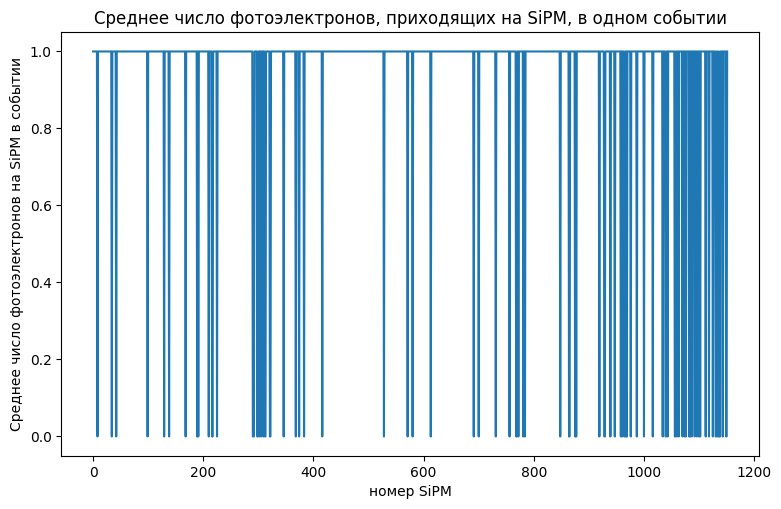

In [72]:
x = summary.keys()
y = [int(el / N) for el in summary.values()]
plt.figure(figsize=(9, 5.5))
plt.title("Среднее число фотоэлектронов, приходящих на SiPM, в одном событии")
plt.xlabel("номер SiPM")
plt.ylabel("Среднее число фотоэлектронов на SiPM в событии")
plt.plot(x, y)
plt.show()

#### Рассчёт эффективностей координатных плоскостей

In [ ]:
def erase(path):
    trash_path = path
    for file in os.listdir(trash_path):
        os.remove(os.path.join(trash_path, file))
erase("Trash")

In [73]:
for t in range(0, 11): # диапазон пороговых значений числа фотоэлектронов
    print(f"Порог: {t}")
    matrix_path = "CHARGED_MATRIX" # расположение папки с данными
    for folder in os.listdir(matrix_path):
        subprocess.Popen(["python", "calculate_efficiency.py", folder, str(t)]) # используем параллельные вычисления для ускорения счёта

    trash_path = "Trash"
    res = []
    while len(os.listdir(trash_path)) != len(os.listdir(matrix_path)): # ждём пока всё посчитается
        pass
    for file in os.listdir(trash_path):
        with open(os.path.join(trash_path, file), 'rb') as l:
            res.append(pickle.load(l))
    erase(trash_path)
    s_1 = [0, 0, 0, 0, 0, 0]
    s_2 = [0, 0, 0, 0, 0, 0]
    for i in range(len(res)):
        s_1 = [s_1[k] + res[i][0][k] for k in range(6)]
        s_2 = [s_2[k] + res[i][1][k] for k in range(6)]
    for i in range(len(s_1)):
        print(f"Эффективность {i + 1} камеры:", s_2[i] / s_1[i])
    print("************************")

Порог: 0
Эффективность 1 камеры: 0.9998947257606063
Эффективность 2 камеры: 0.9986688152455686
Эффективность 3 камеры: 0.9997253973157587
Эффективность 4 камеры: 0.9997597968567703
Эффективность 5 камеры: 0.9984242042231327
Эффективность 6 камеры: 0.999719288396084
************************
Порог: 1
Эффективность 1 камеры: 0.9975085096676843
Эффективность 2 камеры: 0.9972325369578925
Эффективность 3 камеры: 0.9979748052037208
Эффективность 4 камеры: 0.9979068011804269
Эффективность 5 камеры: 0.9966032846587527
Эффективность 6 камеры: 0.998140285624057
************************
Порог: 2
Эффективность 1 камеры: 0.9955082991192056
Эффективность 2 камеры: 0.994990541582008
Эффективность 3 камеры: 0.9962585384272131
Эффективность 4 камеры: 0.9952988813396473
Эффективность 5 камеры: 0.9941870644675561
Эффективность 6 камеры: 0.9964560160005614
************************
Порог: 3
Эффективность 1 камеры: 0.993718637049514
Эффективность 2 камеры: 0.9929587332726126
Эффективность 3 камеры: 0.9948511

#### Реконструкция треков

In [74]:
events_path = "EVENTS_DATA" # расположение папки с данными
for folder in tqdm(os.listdir(events_path)):
    subprocess.Popen(["python", "reconstructe_track.py", folder]) # используем параллельные вычисления для ускорения счёта

res = []
tracks_path = "RECONSTRUCTED_TRACKS"
events_count = len(os.listdir(events_path))
erase(tracks_path)
while len(os.listdir(tracks_path)) != events_count: # ждём пока всё посчитается
    pass
for file in tqdm(os.listdir(tracks_path)):
    with open(os.path.join(tracks_path, file), 'rb') as l:
        res.append(pickle.load(l))

100%|██████████| 11/11 [00:00<00:00, 62.74it/s]


#### Построение треков

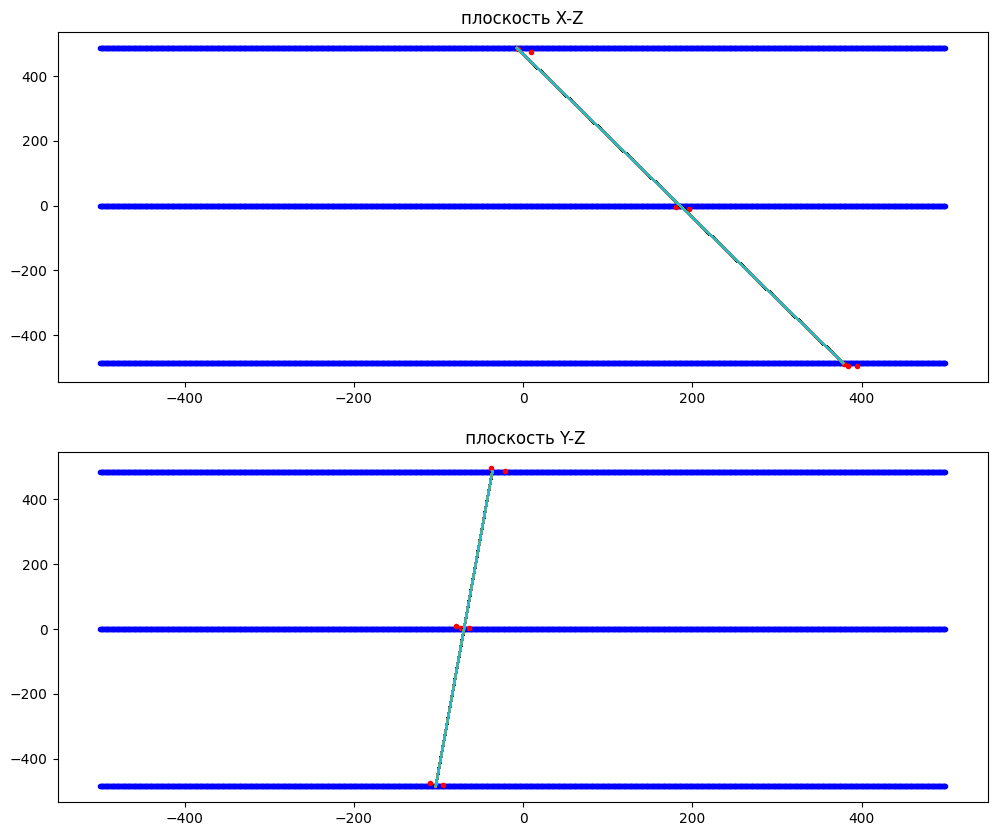

In [75]:
def track(x, xz):
    delta = 10.2
    arr = [[(x[0], xz[0])]]
    for i in range(1, len(xz)):
        k = (xz[i] - xz[0]) / (x[i] - x[0])
        b = xz[0] - k * x[0]
        for j in range(2, len(xz)):
            try:
                if x[j] - delta < (xz[j] - b) / k and (xz[j] - b) / k < x[j] + delta:
                    arr[-1].append((x[j], xz[j]))
            except:
                pass
        arr.append([])
    
    k = 0
    for i in range(len(arr)):
        if len(arr[i]) > len(arr[k]):
            k = i
    
    x_r = [el[0] for el in arr[k]]
    z_r = [el[1] for el in arr[k]]
    k, b = mse(x_r, z_r)
    return k, b


plt.figure(figsize=(12, 10))

x_p = np.arange(-500, 500, 1)
y_p = np.arange(-500, 500, 1)
z_1 = [-485.8 for _ in range(-500, 500, 1)]
z_2 = [0 for _ in range(-500, 500, 1)]
z_3 = [485.8 for _ in range(-500, 500, 1)]

m = 0
n = 60
t = res[m][n] # выбор номеров треков
'''
в массив res были отобраны все треки, содержащие мюоны
красные точки - сработавшие стрипы
синие точки - координатные плоскости
линии - реконструированные треки
индекс m принимает значение от 0 до 11 (количество числа папок)
'''
x = [el[0] for el in t if el[0] != None]
y = [el[1] for el in t if el[1] != None]
xz = [el[2] for el in t if el[0] != None]
yz = [el[2] for el in t if el[1] != None]

k_1, b_1 = track(x, xz)
k_2, b_2 = track(y, yz)

plt.subplot(2, 1, 1, title="плоскость X-Z")
plt.plot(x_p, z_1, '.', color="b")
plt.plot(x_p, z_2, '.', color="b")
plt.plot(x_p, z_3, '.', color="b")
plt.plot(x, xz, ".", color='r')
plt.plot([(z_1[0] - b_1) / k_1, (z_3[0] -b_1) / k_1], [z_1, z_3])
plt.subplot(2, 1, 2, title=" плоскость Y-Z")
plt.plot(y_p, z_1, '.', color="b")
plt.plot(y_p, z_2, '.', color="b")
plt.plot(y_p, z_3, '.', color="b")
plt.plot(y, yz, '.', color='r')
plt.plot([(z_1[0] - b_2) / k_2, (z_3[0] -b_2) / k_2], [z_1, z_3])
plt.show()
